### 基于keras的 cifar10 分类卷积神经网络 

In [10]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [11]:
#数据，切分为训练和测试集。
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 将类向量转换为二进制类矩阵。
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 可视化

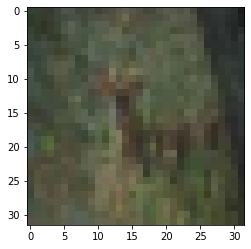

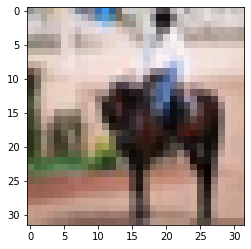

In [12]:
import matplotlib.pyplot as plt
plt.imshow(x_train[10])
plt.show()
plt.imshow(x_train[11])
plt.show()

### 构建神经网络

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary()) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 15, 64)       

### 优化器

In [13]:
# 初始化 RMSprop 优化器。
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# 利用 RMSprop 来训练模型。
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


### 设置神经网络的参数

In [16]:
batch_size = 32
num_classes = 10
epochs = 1
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### 数据增强

In [17]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # 这一步将进行数据处理和实时数据增益。data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # 将整个数据集的均值设为0
        samplewise_center=False,  # 将每个样本的均值设为0
        featurewise_std_normalization=False,  # 将输入除以整个数据集的标准差
        samplewise_std_normalization=False,  # 将输入除以其标准差
        zca_whitening=False,  # 运用 ZCA 白化
        zca_epsilon=1e-06,  # ZCA 白化的 epsilon值
        rotation_range=0,  # 随机旋转图像范围 (角度, 0 to 180)
        # 随机水平移动图像 (总宽度的百分比)
        width_shift_range=0.1,
        # 随机垂直移动图像 (总高度的百分比)
        height_shift_range=0.1,
        shear_range=0.,  # 设置随机裁剪范围
        zoom_range=0.,  # 设置随机放大范围
        channel_shift_range=0.,  # 设置随机通道切换的范围
        # 设置填充输入边界之外的点的模式
        fill_mode='nearest',
        cval=0.,  # 在 fill_mode = "constant" 时使用的值
        horizontal_flip=True,  # 随机水平翻转图像
        vertical_flip=False,  # 随机垂直翻转图像
        # 设置缩放因子 (在其他转换之前使用)
        rescale=None,
        # 设置将应用于每一个输入的函数
        preprocessing_function=None,
        # 图像数据格式，"channels_first" 或 "channels_last" 之一
        data_format=None,
        # 保留用于验证的图像比例（严格在0和1之间）
        validation_split=0.0)

    # 计算特征标准化所需的计算量
    # (如果应用 ZCA 白化，则为 std，mean和主成分).
    datagen.fit(x_train)

    # 利用由 datagen.flow() 生成的批来训练模型
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)





Using real-time data augmentation.
1563/1563 [==============================] - 138s 88ms/step - loss: 2.1476 - accuracy: 0.2050 - val_loss: 1.9632 - val_accuracy: 0.3011


### 训练模型

In [18]:
# 保存模型和权重
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# 评估训练模型
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /Users/lucyqv/Documents/mba/code/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 4s 14ms/step - loss: 1.9632 - accuracy: 0.3011
Test loss: 1.9631593227386475
Test accuracy: 0.3010999858379364


In [26]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
np.random.seed(10)
X_train = x_train.reshape(50000,3072).astype('float32')
X_test = x_test.reshape(10000,3072).astype('float32')
X_train = X_train/255
X_test = X_test/255


In [27]:
from sklearn import svm
model = svm.SVC(C=10.0, kernel='linear')
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
print('Score:',model.score(X_test,y_test))

ValueError: y should be a 1d array, got an array of shape (50000, 10, 2) instead.